In [2]:
import os

import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from scipy.integrate import simpson
from tqdm.notebook import tqdm

from lib import merge_in_geometry

In [3]:
plt.style.use('dark_background')  # for cool points

In [4]:
years = list(range(2017, 2023))  # years we have POUS data for
outage_threshold = 0.05  # OutageFraction above this is considered an outage
resample_freq = "1D"  # resample raw hourly data to this resolution, then check for outage state
start_buffer = "2D"  # when plotting outage timeseries, start this delta ahead of first outage period
end_buffer = "1W"  # when plotting outage timeseries, end this delta after last outage period
pairwise_distance_threshold_days = 7  # group outage events within this many days of each other

root_dir = "data"
states = pd.read_csv(
    os.path.join(
        root_dir,
        "raw",
        "states",
        "state_codes.csv"
    )
).set_index("state_fips_code")
county_boundaries: gpd.GeoDataFrame = gpd.read_file(
    os.path.join(
        root_dir,
        "raw",
        "counties",
        "cb_2018_us_county_500k.shp"
    )
)
outage_integrals_path = os.path.join(
    root_dir,
    "processed",
    "outage",
    f"{resample_freq}_county_outage_integrals.csv"
)
outage_attr_path = os.path.join(
    root_dir,
    "processed",
    "outage",
    f"{resample_freq}_{outage_threshold}_outage_attributes_for_clustering.csv"
)

In [5]:
# read source data
data_by_year = {}
for year in years:
    processed_path = os.path.join(root_dir, f"processed/outage/{year}.parquet")
    data = pd.read_parquet(processed_path)
    data.OutageFraction = np.clip(data.OutageFraction, 0, 1)
    data_by_year[year] = data

# find set of all counties in data
counties = set()
for year, data in data_by_year.items():
    counties = counties | set(data.index.get_level_values("CountyFIPS"))
counties = sorted(counties)

# another view of source data, concat into single dataframe
all_counties_hourly = pd.concat(data_by_year).drop(columns=["CustomersTracked", "CustomersOut"])
all_counties_hourly = all_counties_hourly.droplevel(0)

In [6]:
# construct complete timeseries
# resample to resample_freq and take mean of OutageFraction
# save to disk as cache

if os.path.exists(outage_integrals_path):
    df = pd.read_csv(outage_integrals_path, dtype={"CountyFIPS": str})    
    
else:
    resampled_data_by_year = []
    for county_code in tqdm(counties):

        # whole timeseries April-October for single county
        for year in years:
            df = data_by_year[year]
            try:
                data = df.loc(axis=0)[:, county_code].reset_index(level="CountyFIPS")
                complete_index = pd.date_range(f"{year}-04-01", f"{year}-10-31", freq="1H")
                data = data.reindex(index=complete_index, fill_value=0)
                data.index.name = "RecordDateTime"
            except KeyError:
                continue

            data = data.drop(columns=["CountyFIPS"]).resample(resample_freq).mean()
            data["CountyFIPS"] = county_code
            resampled_data_by_year.append(data)
            
    df = pd.concat(resampled_data_by_year)
    df.to_csv(outage_integrals_path)

In [7]:
if os.path.exists(outage_attr_path):
    outage_attributes = pd.read_csv(outage_attr_path, dtype={"CountyFIPS": str})

else:   
    data_start: pd.Timestamp = pd.to_datetime(f"{min(years)}-04-01")
    
    # take the resampled data and filter to periods with OutageFraction above a threshold
    outages = df.set_index(pd.to_datetime(df.RecordDateTime)).drop("RecordDateTime", axis=1)
    outages = outages.drop(["CustomersTracked", "CustomersOut"], axis=1)
    outages = outages[outages.OutageFraction > outage_threshold]

    # duration of single resampling period in nanoseconds
    length_of_resample_period_ns = pd.Timedelta(resample_freq).total_seconds() * 1E9

    outage_attributes = []
    for county_code in tqdm(set(outages.CountyFIPS)):

        county_outages_resampled: pd.DataFrame = outages[outages.CountyFIPS == county_code]
        county_data_hourly: pd.DataFrame = all_counties_hourly.loc[(slice(None), county_code), :]

        # picking out runs of resampled outage periods
        start = 0
        outage_period_resampled_indicies: list[tuple[int, int]] = []
        for i, time_gap_ns in enumerate(np.diff(county_outages_resampled.index.values)):
            # should probably check that we are more than a fraction of a nanosecond different
            # 25 hour days etc.
            if float(time_gap_ns) != length_of_resample_period_ns:
                outage_period_resampled_indicies.append((start, i))
                start = i + 1

        county_centroid = county_boundaries.set_index("GEOID").loc[county_code].geometry.centroid

        for period_indicies in outage_period_resampled_indicies:

            start_i, end_i = period_indicies
            n_periods: int = end_i - start_i

            # check outage is at least a day long
            if (pd.Timedelta(resample_freq) * n_periods) > pd.Timedelta("1D"):

                # retrieve indicies of resampled run of outage periods
                group_datetimeindex: pd.DatetimeIndex = county_outages_resampled.iloc[start_i: end_i + 1].index

                outage_attributes.append(
                    (
                        county_code,
                        group_datetimeindex[0].date(),
                        (group_datetimeindex[0] - data_start).value / (1E9 * 60 * 60 * 24),
                        group_datetimeindex[0].year,
                        group_datetimeindex[0].day_of_year,
                        n_periods,
                        county_centroid.x,
                        county_centroid.y
                    )
                )
            
            
    outage_attributes = pd.DataFrame(
        outage_attributes,
        columns=[
            "CountyFIPS",
            "start",
            "days_since_data_start",
            "year",
            "day_of_year",
            "n_periods",
            "county_long",
            "county_lat"
        ]
    )
    outage_attributes.to_csv(outage_attr_path, index=False)
    
outage_attributes = outage_attributes.sort_values("days_since_data_start").reset_index()

In [8]:
outage_attributes

,index,CountyFIPS,start,days_since_data_start,year,day_of_year,n_periods,county_long,county_lat
0,7,39113,2017-04-29,28.0,2017,119,3,-84.290645,39.754603
1,762,39047,2017-04-29,28.0,2017,119,2,-83.456087,39.559876
2,208,42113,2017-05-02,31.0,2017,122,2,-76.512235,41.446158
3,211,42015,2017-05-02,31.0,2017,122,2,-76.515386,41.788697
4,173,39001,2017-05-14,43.0,2017,134,3,-83.472032,38.845617
...,...,...,...,...,...,...,...,...,...
860,435,54109,2022-06-17,1903.0,2022,168,2,-81.549196,37.609609
861,22,51009,2022-06-18,1904.0,2022,169,2,-79.145146,37.604799
862,75,19135,2022-07-15,1931.0,2022,196,3,-92.869004,41.029796
863,387,06043,2022-07-23,1939.0,2022,204,4,-119.905426,37.581508


In [9]:
def us_admin_name(
    county_code: str,
    county_boundaries: gpd.GeoDataFrame,
    states: pd.DataFrame
) -> tuple[str, str]:
    """
    Lookup county name, containing state name and code, given a 5-digit string county code.
    """
    
    try:
        county_admin_data: pd.Series = \
            county_boundaries.sort_values("GEOID").set_index("GEOID").loc[county_code, :]
        state_code: str = county_admin_data.STATEFP
        state_name: str = states.loc[int(state_code), "state_name"]
        county_name: str = county_admin_data.NAME
    except Exception as e:
        state_name = "-"
        county_name = "-"
        
    return county_name, state_name, state_code

Text(0.5, 1.0, 'Pairwise distance in time')

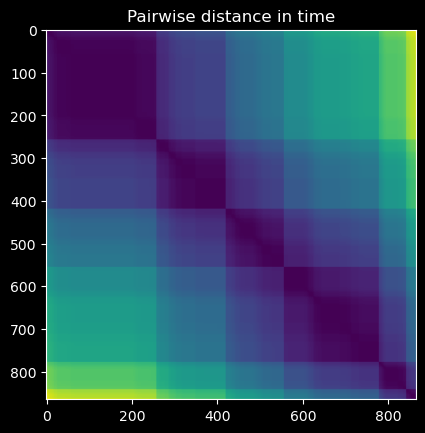

In [10]:
# calculate the pairwise distance in time between outage events
arr = outage_attributes.days_since_data_start.values
distance = np.abs(arr - arr[:, None])
f, ax = plt.subplots()
ax.imshow(distance)
ax.set_title("Pairwise distance in time")

In [12]:
plot_dir = os.path.join(
    "plots",
    "outage_timeseries_county_grouped",
    f"resample_{resample_freq}",
    f"threshold_{outage_threshold}",
    f"pairwise_distance_days_{pairwise_distance_threshold_days}"
)
os.makedirs(plot_dir, exist_ok=True)

all_group_indicies = []
for i, n_days in enumerate(arr):
    group_indicies = outage_attributes.loc[distance[i] < pairwise_distance_threshold_days, :].index
    all_group_indicies.append(tuple(group_indicies))
unique_group_indicies = set(all_group_indicies)

for i, group_indicies in enumerate(unique_group_indicies):
    
    # only interested in events hitting many counties
    if len(group_indicies) < 3:
        continue
    
    event = outage_attributes.loc[list(group_indicies)]
    f, ax = plt.subplots(figsize=(16, 10))
    
    for outage_attr in event.itertuples():

        county_data_hourly: pd.DataFrame = all_counties_hourly.loc[(slice(None), outage_attr.CountyFIPS), :]

        # add a buffer around the start and end of the run
        event_start_datetime = pd.to_datetime(outage_attr.start)
        plot_start: str = str((event_start_datetime - pd.Timedelta(start_buffer)).date())
        event_end_datetime = event_start_datetime + pd.Timedelta(resample_freq) * outage_attr.n_periods
        plot_end: str = str((event_end_datetime + pd.Timedelta(end_buffer)).date())

        county_name, state_name, state_code = us_admin_name(outage_attr.CountyFIPS, county_boundaries, states)
            
        # select our hourly data to plot
        try:
            label_str = f"{county_name}, {states.loc[int(state_code), 'state_alpha_2_code']}"
        except Exception as e:
            label_str = f"{county_name}, ?"
        county_data_hourly.droplevel(1).loc[plot_start: plot_end, "OutageFraction"].plot(
            ax=ax,
            x_compat=True,  # enforce standard matplotlib date tick labelling "2023-09-21"
            label=label_str
        )
        
    ax.set_ylabel("OutageFraction", labelpad=20)
    ax.set_xlabel("Time", labelpad=20)
    ax.set_ylim(0, 1.1)
    ax.grid(alpha=0.3)
    ax.legend(ncols=max(1, len(group_indicies) // 20))
     
    plt.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.91)

    f.savefig(
        os.path.join(
            plot_dir,
            f"{plot_start}_{plot_end}.png"
        )
    )
    plt.close(f)